## Motivation

Analyzing chromatin accessibility and gene expression together to understand gene regulation is helpful due to mechanistic relationship between those two during the control of gene regulation, mediated through transcription factors and other epigenetic modulators {cite}`Spitz2012-sw`. Briefly, regulatory regions annotated as promoters and local/distal enhancers act during the early phases of gene expression regulation, and their accessibility increase of decrease can be used as a proxy for changes in its overall state. Hence, the global positive or negative correlation between proximal and distal accessible elements and target genes within a genome neighborhood distance (e.g. less than 200 Mbp), is a way to annotate genomic regulatory relationships and include those during the inference of Gene Regulatory Networks (GRNs). Using sequencing data describing gene (RNA) and peak (ATAC) features, tools that build correlation matrices between peaks and matrices are useful for summarizing the strongest interactions.

### Gene regulatory network inference using RNA and ATAC features

In this notebook, we will use the package **FigR** {cite}`Kartha2022-lp` to describe such GRN-building steps on a donor of the NeurIPs dataset. Preparation scripts of this notebook will also call cisTopic {cite}`Bravo_Gonzalez-Blas2019-zj` to generate peak clusters or **topics** from the ATAC seq counts matrix. During the calculation of RNA-ATAC correlations, FigR uses ChromVAR {cite}`Schep2017-vi` to map Transcription Factor motifs to the mapped peaks. The main processing steps described in this notebook are adapted based on FigR's core tutorial for SHARE-seq data [Tutorial](https://buenrostrolab.github.io/FigR/articles/FigR_shareseq.html)

Disclaimer: At the time of writing this chapter, several methods that utilize single-cell RNA and ATAC information for GRN inference are currently available. Due to similar benchmarking reasons as the one indicated in the previous chapter, we cannot say that these methods will perform best in the majority of scenarios. We globally recommend either of those as a starting point, given available data, to infer preliminary GRNs.


### Environment setup

In [2]:
# the installation of this package is required for the proper execution of this notebook.
if(!require("FigR"))
    devtools::install_github("caleblareau/BuenColors") # the package BuenColors is also a devtools dependency to install FigR.
    devtools::install_github("buenrostrolab/FigR")

Loading required package: FigR

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘FigR’”




── R CMD build ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
✔  checking for file ‘/tmp/Rtmp4PkbRP/remotes9cc14bfee09/caleblareau-BuenColors-f1bc8e6/DESCRIPTION’
─  preparing ‘BuenColors’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
   Removed empty directory ‘BuenColors/figure’
   Omitted ‘LazyData’ from DESCRIPTION
─  building ‘BuenColors_0.5.6.tar.gz’
   


rlemon    (NA -> 0.2.0  ) [CRAN]
FNN       (NA -> 1.1.3.1) [CRAN]
optmatch  (NA -> 0.10.5 ) [CRAN]
pbmcapply (NA -> 1.5.1  ) [CRAN]
ggrepel   (NA -> 0.9.2  ) [CRAN]
doSNOW    (NA -> 1.0.20 ) [CRAN]
cowplot   (NA -> 1.1.1  ) [CRAN]


Skipping 5 packages not available: ComplexHeatmap, chromVAR, GenomicRanges, SummarizedExperiment, motifmatchr

Installing 7 packages: rlemon, FNN, optmatch, pbmcapply, ggrepel, doSNOW, cowplot

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



── R CMD build ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
✔  checking for file ‘/tmp/Rtmp4PkbRP/remotes9cc636c76d/buenrostrolab-FigR-310285d/DESCRIPTION’
─  preparing ‘FigR’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘FigR_0.1.0.tar.gz’
   Warning in utils::tar(filepath, pkgname, compression = compression, compression_level = 9L,  :
     storing paths of more than 100 bytes is not portable:
     ‘FigR/docs/deps/bootstrap-5.1.0/fonts/memQYaGs126MiZpBA-UFUIcVXSCEkx2cmqvXlWq8tWZ0Pw86hd0Rk5hkWVAexg.woff’
   Warning in utils::tar(filepath, pkgname, compression = compression, compression_level = 9L,  :
     storing paths of more than 100 bytes is not portable:
     ‘FigR/docs/deps/bootstrap-5.

In [3]:
suppressMessages(library(FigR))

The data that downloaded belongs to a shareseq dataset, and it is part of the core FigR tutorials.

In [4]:
# for faster computing, here we define a subset of features
ncells = -1 # -1 if using all cell
nfeatures_rna = 9500 # -1 if using all rna features
nfeatures_atac = 9500 # -1 if using all atac features

Load multiome data from NeurIPs (donor s1d1)

Loading RNA

In [5]:
library(Matrix)
m <- read.csv('../../data/openproblems_bmmc_multiome_genes_filtered_rna_s1d1.csv.gz', nrows=ncells, row.names=1)
print(dim(m))
# this is a cells x genes matrix, so we have to transpose it to match with FigR (genes x cells)

[1]  6224 13431


In [6]:
m <- m[,1:min(dim(m)[2], nfeatures_rna)]
RNAmat <- t(as(as.matrix(m), "sparseMatrix"))
dim(RNAmat)

[1] 9500 6224

### Load the ATAC seq data

In [7]:
obs <- read.csv('../../data/openproblems_bmmc_multiome_genes_filtered_atac_s1d1_obs.csv.gz', row.names=1, nrows=ncells)
dim(obs)

[1] 6224   30

Convert the raw counts from donor s1d1 into a SummarizedExperiment object

In [8]:
library(SummarizedExperiment)

Load peak counts for donor s1d1

In [9]:
ATAC <- read.csv('../../data/openproblems_bmmc_multiome_genes_filtered_atac_s1d1_counts_features_times_cells_npeaks15000.csv.gz', nrows=nfeatures_atac, row.names=1)
print(dim(ATAC))

if(ncells != -1)
    ATAC <- ATAC[c(1:nfeatures_atac),c(1:(ifelse(ncells == -1, ncol(ATAC), ncells) + 3))]

ATAC <- subset(ATAC, (is.na(ATAC$start) == FALSE) & (is.na(ATAC$end) == FALSE)) # remove NA start/end columns
ATAC <- subset(ATAC, grepl('chr', ATAC$chr)) # filter non-canonical chromosomes.

print(dim(ATAC))

[1] 9500 6227
[1] 9500 6227


Convert into SummarizedExperiment object and convert the assay to a sparse matrix

In [10]:
ATAC.se <- makeSummarizedExperimentFromDataFrame(ATAC)
# the assay has to be a sparse matrix
counts(ATAC.se) <- assay(ATAC.se)
assay(ATAC.se) <- as(assay(ATAC.se), 'sparseMatrix')
ATAC_colData <- read.csv('../../data/openproblems_bmmc_multiome_genes_filtered_atac_s1d1_obs.csv.gz', nrows=ncells, row.names=1)
print(ATAC.se)

class: RangedSummarizedExperiment 
dim: 9500 6224 
metadata(0):
assays(2): '' counts
rownames(9500): chr1-633515-634474 chr1-827067-827948 ...
  chr3-58332489-58333337 chr3-58340451-58341378
rowData names(0):
colnames(6224): TAGTTGTCACCCTCAC.1.s1d1 CTATGGCCATAACGGG.1.s1d1 ...
  TACGTACAGGAAACTG.1.s1d1 GGTTTCTGTTTATCTG.1.s1d1
colData names(0):


Setup the colData columns from ATAC

In [11]:
suppressWarnings(for(c in colnames(ATAC_colData)){
    # print(c)
    colData(ATAC.se)[c] <- ATAC_colData[c]
})

In [12]:
c(dim(ATAC.se), dim(RNAmat))

[1] 9500 6224 9500 6224

Preprocessing of SummarizedExperimentObject using the number of cells

In [13]:
set.seed(123)
# cellsToKeep <- sample(colnames(ATAC.se), size = 10000, replace = FALSE)
# ATAC.se <- ATAC.se[,cellsToKeep]
# RNAmat <- RNAmat[,cellsToKeep]

# Remove genes with zero expression across all cells
RNAmat <- RNAmat[Matrix::rowSums(RNAmat) != 0,]

### Preparation and execution of cisTopic

cisTopic applies Latent Dirichlet allocation to define a number of "topics" that are able to summarize the variability of the observed chromatin accessibility counts retrieved by ATAC-seq. Here, we install, calculate of the cisTopic object using scATAC-seq, and use it downstream as input for FigR.

Installation of cisTopic through devtools (if required). This installation takes approximately ten minutes, due to cisTopic-specific dependencies.

In [14]:
if(!require("cisTopic"))
    devtools::install_github("aertslab/cisTopic")

Loading required package: cisTopic

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘cisTopic’”



lgr          (NA -> 0.4.4     ) [CRAN]
RhpcBLASctl  (NA -> 0.21-247.1) [CRAN]
float        (NA -> 0.3-0     ) [CRAN]
MatrixExtra  (NA -> 0.1.13    ) [CRAN]
mlapi        (NA -> 0.1.1     ) [CRAN]
rsparse      (NA -> 0.5.1     ) [CRAN]
fitdistrplus (NA -> 1.1-8     ) [CRAN]
text2vec     (NA -> 0.6.3     ) [CRAN]
lda          (NA -> 1.4.2     ) [CRAN]


Installing 9 packages: lgr, RhpcBLASctl, float, MatrixExtra, mlapi, rsparse, fitdistrplus, text2vec, lda

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



── R CMD build ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
✔  checking for file ‘/tmp/Rtmp4PkbRP/remotes9cc79740933/aertslab-cisTopic-f39fe9d/DESCRIPTION’
─  preparing ‘cisTopic’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘cisTopic_0.3.0.tar.gz’
   


In [15]:
suppressMessages(library(cisTopic))

Warning message:
“replacing previous import ‘GenomicRanges::shift’ by ‘data.table::shift’ when loading ‘cisTopic’”
Warning message:
“replacing previous import ‘data.table::last’ by ‘dplyr::last’ when loading ‘cisTopic’”
Warning message:
“replacing previous import ‘GenomicRanges::union’ by ‘dplyr::union’ when loading ‘cisTopic’”
Warning message:
“replacing previous import ‘GenomicRanges::intersect’ by ‘dplyr::intersect’ when loading ‘cisTopic’”
Warning message:
“replacing previous import ‘GenomicRanges::setdiff’ by ‘dplyr::setdiff’ when loading ‘cisTopic’”
Warning message:
“replacing previous import ‘data.table::first’ by ‘dplyr::first’ when loading ‘cisTopic’”
Warning message:
“replacing previous import ‘data.table::between’ by ‘dplyr::between’ when loading ‘cisTopic’”
Warning message:
“replacing previous import ‘dplyr::failwith’ by ‘plyr::failwith’ when loading ‘cisTopic’”
Warning message:
“replacing previous import ‘dplyr::id’ by ‘plyr::id’ when loading ‘cisTopic’”
Warning message:
“

The following script requires indicating a number of cores (`nCores`). Increase according to computing resources available

In [16]:
nCores = 2

In [17]:
cistopic_bkp_path <- "../../data/openproblems_bmmc_multiome_genes_filtered_atac_s1d1_counts_cisTopic.rds"
if(nfeatures_atac != -1)
    cistopic_bkp_path <- paste0("../../data/openproblems_bmmc_multiome_genes_filtered_atac_s1d1_counts_cisTopic_npeaks", nfeatures_atac, ".rds")
print(cistopic_bkp_path)

[1] "../../data/openproblems_bmmc_multiome_genes_filtered_atac_s1d1_counts_cisTopic_npeaks9500.rds"


[1] "Formatting data..."
[1] "Exporting data..."
[1] "Running models..."


Loading required package: umap



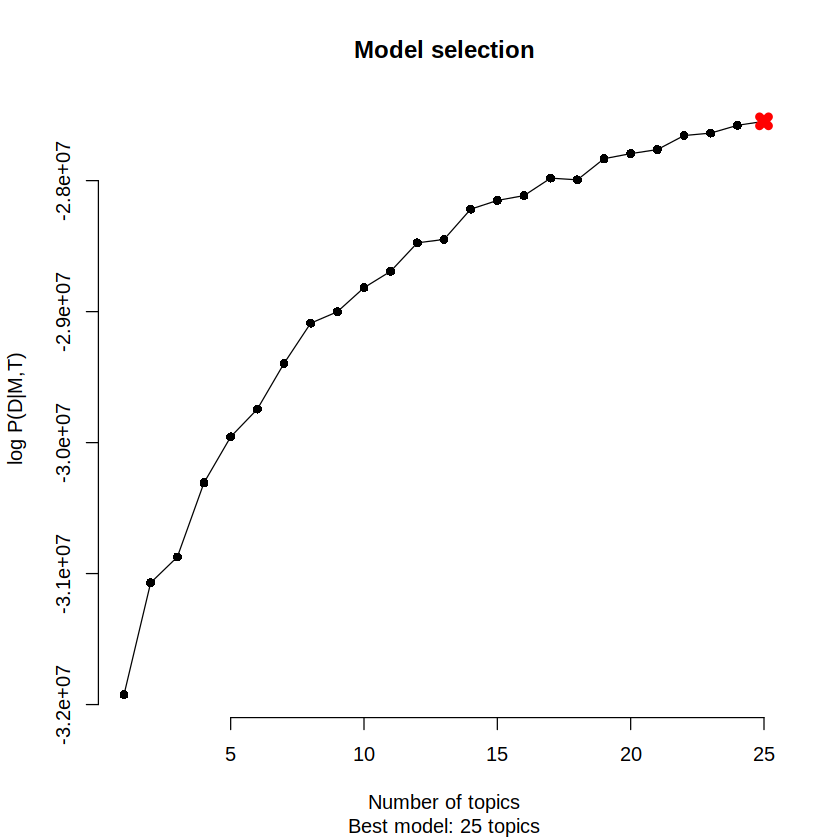

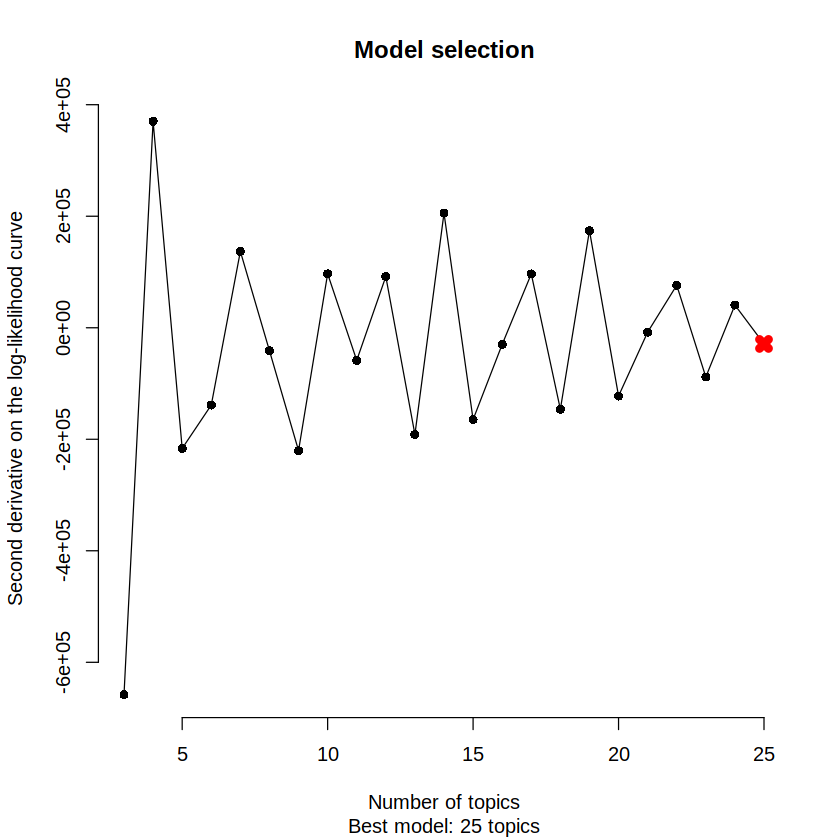

In [20]:
if(!file.exists(cistopic_bkp_path) || TRUE){
    # the number of topics to test
    n_topics = 1:25

    atac <- read.csv('../../data/openproblems_bmmc_multiome_genes_filtered_atac_s1d1_counts_features_times_cells_npeaks20000.csv.gz', row.names=1)
    rownames(atac) <- paste0(atac$chr, ':', atac$start, '-', atac$end)
    
    # the columns indicated here need to be removed during cisTopic operations
    atac$chr <- NULL
    atac$start <- NULL
    atac$end <- NULL
    # head(atac, 2)
    
    cisTopicObject <- createcisTopicObject(atac, project.name='neurips_s1d1')
    cisTopicObject <- runCGSModels(cisTopicObject, topic=c(n_topics), # , 5:15, 20, 25), # topic=c(2, 5:15, 20, 25),
                               seed=987, nCores=nCores, burnin = 90,
                               iterations = 100, addModels=FALSE)
    
    cisTopicObject <- selectModel(cisTopicObject, type='maximum')

    # cisTopicObject
    cisTopicObject <- runUmap(cisTopicObject, target='cell')

    topic.mat <- modelMatSelection(cisTopicObject, 'cell', 'Probability')
    topic.mat <- t(topic.mat)
    topic.mat <- as.matrix(topic.mat)
    saveRDS(topic.mat, cistopic_bkp_path)
}


In [21]:
print('done calculating CisTopic object')

[1] "done calculating CisTopic object"


Once the CisTopic object is generated, we can use it to extract relevant features

In [22]:
cisAssign <- readRDS(cistopic_bkp_path)
dim(cisAssign) # Cells x Topics

# all(cellsToKeep %in% rownames(cisAssign))
# # Subset
# cisAssign <- cisAssign[cellsToKeep,]

[1] 6224   25

Calculate a kNN-graph using the topics matrix from cisTopic

In [23]:
library(dplyr)
library(FNN)

In [24]:
set.seed(123)
cellkNN <- get.knn(cisAssign, k = 30)$nn.index
dim(cellkNN)
# rownames(cellkNN) <- cellsToKeep

[1] 6224   30

Visualize cells using traditional UMAP

In [25]:
colData(ATAC.se)$cellAnnot <- colData(ATAC.se)$cell_type

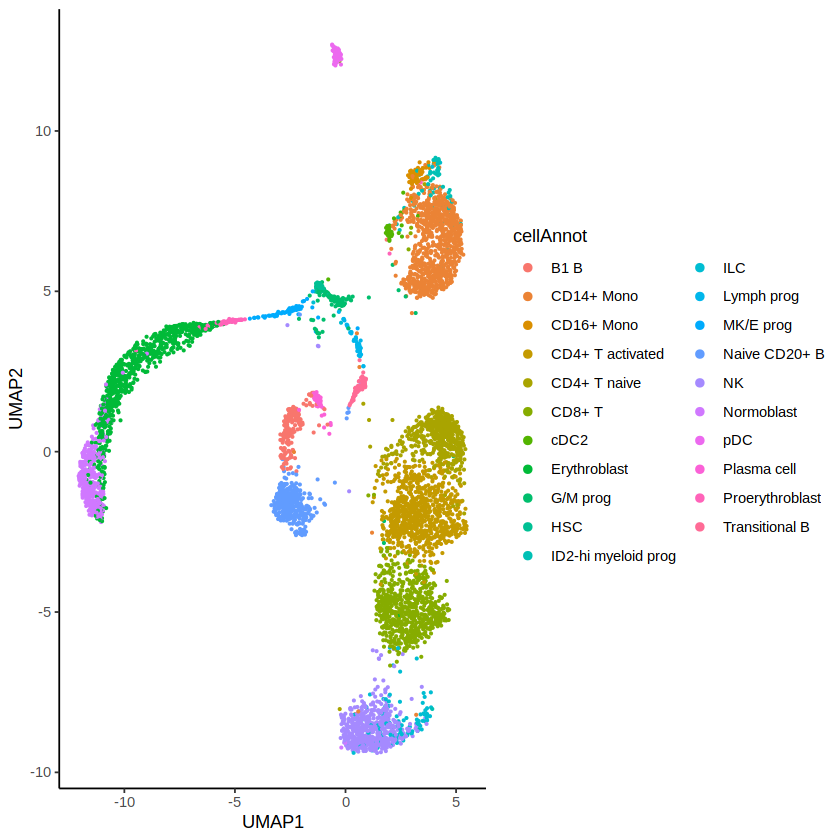

In [26]:
# Plot
library(ggplot2)
colData(ATAC.se) %>% as.data.frame() %>% ggplot(aes(UMAP1,UMAP2,color=cellAnnot)) + 
  geom_point(size=0.5) + # scale_color_manual(values=annoCols)+
  theme_classic() + guides(colour = guide_legend(override.aes = list(size=2)))

The main FigR algorithm is executed here.

In [30]:
suppressMessages(library(BSgenome.Hsapiens.UCSC.hg38))

In [31]:
# check object dimensions
c(dim(ATAC.se), dim(RNAmat))

[1] 9500 6224 9500 6224

The following script requires indicating a number of cores (`nCores`). Increase according to computing resources available

In [32]:
nCores = 2

The runGenePeakcorr function cannot be run interactively, and it requires to be executed in a terminal using R

In [33]:
# This snippet can be run interactively, but it takes a long time.
bkp_path_ciscorr <- '../../data/openproblems_bmmc_multiome_genes_filtered_s1d1_ciscorr.rds'
if(nfeatures_atac != -1)
    cistopic_bkp_path <- paste0("../../data/openproblems_bmmc_multiome_genes_filtered_s1d1_ciscorr_npeaks", nfeatures_atac, ".rds")
print(c(file.exists(bkp_path_ciscorr), cistopic_bkp_path))

if(!file.exists(bkp_path_ciscorr)){
    cisCorr <- FigR::runGenePeakcorr(ATAC.se = ATAC.se,
                               RNAmat = RNAmat,
                               genome = "hg38", # One of hg19, mm10 or hg38
                               nCores = nCores,
                               p.cut = NULL, # Set this to NULL and we can filter later
                               n_bg = 250)
    saveRDS(cisCorr, bkp_path_ciscorr)
}
cisCorr <- readRDS(bkp_path_ciscorr)

[1] "TRUE"                                                                            
[2] "../../data/openproblems_bmmc_multiome_genes_filtered_s1d1_ciscorr_npeaks9500.rds"


Filter relevant peak-gene correlations by p-value

In [34]:
cisCorr.filt <- cisCorr %>% filter(pvalZ <= 0.05)
print(c('all associations', nrow(cisCorr)))
print(c('filtered associations', nrow(cisCorr.filt)))

[1] "all associations" "2534"            
[1] "filtered associations" "490"                  


In [35]:
if(nrow(cisCorr.filt) == 0)
    print('increase the number of cells/peaks/genes to discover more associations')
stopifnot(nrow(cisCorr.filt) > 0)

Once the Peak and Gene correlations have been calculated, FigR groups ATAC-seq peaks into Domains of regulatory chromatin (DORCs). These groups are useful to describe relationships between the expression of TFs RNA levels with the overall change of multiple chromatin-accessible elements around a gene. Importantly, if multiple of those chromatin-accessible elements in a DORC also contain DNA-binding motifs related to the TF of interest, both lines of evidence are useful for broadly describing TF activators (TF motif enrichment and positive DORC - TF RNA correlation) or TF repressors (TF motif enrichment and negative DORC - TF RNA correlation).

[1] 47


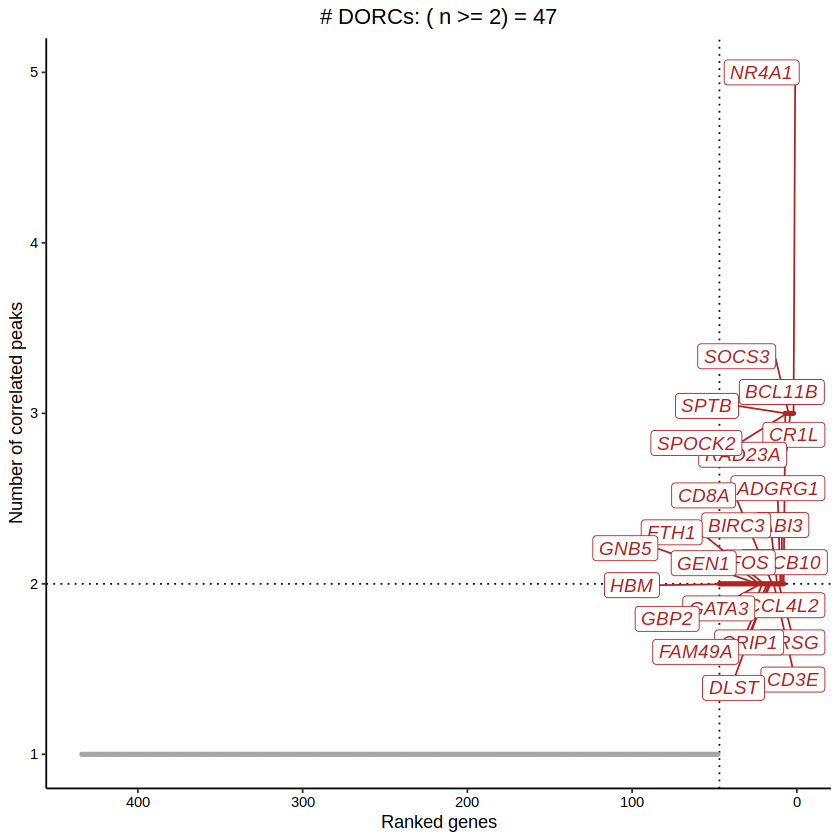

In [36]:
# Determine DORC genes
dorcGenes <- cisCorr.filt %>% dorcJPlot(cutoff=2, # Default
                                       returnGeneList = TRUE)
print(length(dorcGenes))

Modify the cutoff here to recover at last 30 genes. Otherwise, the runFigRGRN could not be executed.

In [37]:
stopifnot(length(dorcGenes) > 30)

Get DORC scores

In [38]:
dorcMat <- getDORCScores(ATAC.se, dorcTab=cisCorr.filt, geneList=dorcGenes, nCores=nCores)
# Smooth DORC scores (using cell KNNs)

Running DORC scoring for 47 genes: NR4A1
BCL11B
CR1L
RAD23A
SOCS3
SPOCK2
SPTB
ABCB10
ABI3
ADGRG1
ARSG
BIRC3
CCL4L2
CD3E
CD8A
CRIP1
DLST
FAM49A
FOS
FTH1
GATA3
GBP2
GEN1
GNB5
HBM
IFI30
IMMT
LTBP1
MAF
METRNL
MRPS21
NELL2
NLRP12
PABPC4
PCGF5
RAB20
RGS10
RHEBL1
RUNX3
SLC5A6
SLC7A5
SPC24
SPI1
TAGLN2
TMPRSS9
YES1
ZNF219



........
Normalizing scATAC counts ..
Centering counts for cells sequentially in groups of size  5000  ..

Computing centered counts for cells:  1  to  5000 ..
Computing centered counts per cell using mean reads in features ..

Computing centered counts for cells:  5001  to  6224 ..
Computing centered counts per cell using mean reads in features ..

Merging results..
Done!
Computing DORC scores ..
Running in parallel using  2 cores ..

Time Elapsed:  0.236963510513306 secs 



In [39]:
stopifnot(nrow(cellkNN) == ncol(dorcMat))

In [40]:
rownames(cellkNN) <- colnames(dorcMat)

To execute the smoothScores NN function with multiple cores, doParallel is required.

In [41]:
library(doParallel)

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



In [42]:
# Smooth dorc scores using cell KNNs (k=30)
dorcMat.s <- smoothScoresNN(NNmat = cellkNN[,1:30], mat = dorcMat, nCores = nCores)

Number of cells in supplied matrix:  6224 
Number of genes in supplied matrix:  47 
Number of nearest neighbors being used per cell for smoothing:  30 
  |                                                                      |   0%Running in parallel using  2 cores ..
  |======================================================================| 100%
Merging results ..

Time Elapsed:  11.7726874351501 secs 


In [43]:
stopifnot(nrow(cellkNN) == ncol(RNAmat))

In [44]:
rownames(cellkNN) <- colnames(RNAmat)

In [45]:
# Smooth RNA using cell KNNs
# This takes longer since it's all genes
RNAmat.s <- smoothScoresNN(NNmat = cellkNN[,1:30], mat = RNAmat, nCores = nCores)

Number of cells in supplied matrix:  6224 
Number of genes in supplied matrix:  9500 
Number of nearest neighbors being used per cell for smoothing:  30 
  |                                                                      |   0%Running in parallel using  2 cores ..
  |======================================================================| 100%
Merging results ..

Time Elapsed:  1.52926950454712 mins 


In [49]:
library(ggplot2)
library(ggrastr)

In [50]:
# Visualize on pre-computed UMAP
umap.d <- as.data.frame(colData(ATAC.se)[,c("UMAP1","UMAP2")])

Once the DORC scores are calculated, we can explore associations between TFs and target genes, or the overall expression of TFs in each of cell types. Those two metrics contribute to an understanding of how cell types. 

In [51]:
dorcGenes

[1] "NR4A1"   "BCL11B"  "CR1L"    "RAD23A"  "SOCS3"   "SPOCK2"  "SPTB"   
 [8] "ABCB10"  "ABI3"    "ADGRG1"  "ARSG"    "BIRC3"   "CCL4L2"  "CD3E"   
[15] "CD8A"    "CRIP1"   "DLST"    "FAM49A"  "FOS"     "FTH1"    "GATA3"  
[22] "GBP2"    "GEN1"    "GNB5"    "HBM"     "IFI30"   "IMMT"    "LTBP1"  
[29] "MAF"     "METRNL"  "MRPS21"  "NELL2"   "NLRP12"  "PABPC4"  "PCGF5"  
[36] "RAB20"   "RGS10"   "RHEBL1"  "RUNX3"   "SLC5A6"  "SLC7A5"  "SPC24"  
[43] "SPI1"    "TAGLN2"  "TMPRSS9" "YES1"    "ZNF219"

One of the strongest genes in terms of peaks correlated with TF expression is NR4A1. This is a Nuclear Receptor

In [52]:
marker_gene = 'NR4A1'

In [53]:
dorcg <- plotMarker2D(umap.d,dorcMat.s,markers = c(marker_gene),maxCutoff = "q0.99",
                      colorPalette = "brewer_heat") + ggtitle(paste0(marker_gene, ' DORC'))


Plotting  NR4A1 


In [54]:
rnag <- plotMarker2D(umap.d,RNAmat.s,markers = c(marker_gene),maxCutoff = "q0.99",
                     colorPalette = "brewer_purple") + ggtitle(paste0(marker_gene, ' RNA'))

Plotting  NR4A1 


Using patchwork, we can merge the dorcg and rnag objects, and visualize those interatively

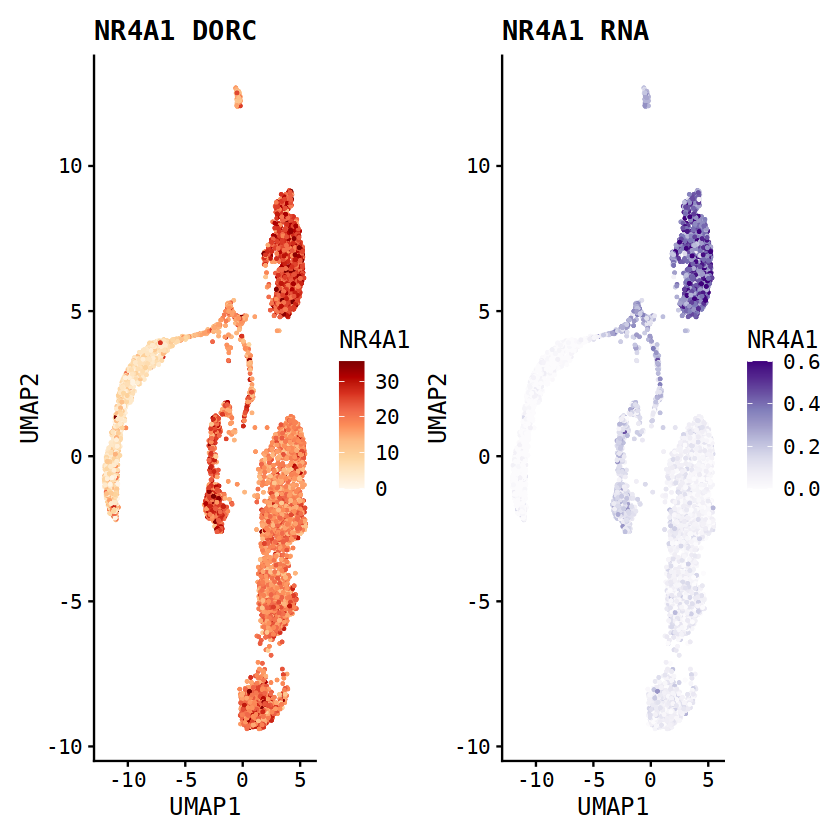

In [71]:
library(patchwork)
cowplot_mono <- cowplot::theme_cowplot(font_family='mono')
dorcg + cowplot_mono + rnag + cowplot_mono

Through a visual comparison, we can identify that the agreement between NR4A1 expression and DORC scores is not 1-to-1, meaning that in some cell type clusters NR4A1 is strongly expressed, yet there is no strong correlation between those expression levels and ATAC peaks putatively occupied with NR4A1.

In [58]:
dim(dorcMat.s)

[1]   47 6224

In [59]:
figR.d <- runFigRGRN(ATAC.se = ATAC.se, # Must be the same input as used in runGenePeakcorr()
                     dorcTab = cisCorr.filt, # Filtered peak-gene associations
                     genome = "hg38",
                     dorcMat = dorcMat.s,
                     rnaMat = RNAmat.s,
                     nCores = nCores)

Assuming peak indices in Peak field

Removing genes with 0 expression across cells ..




Getting peak x motif matches ..
Determining background peaks ..
Using  50  iterations ..

Testing  623  TFs
Testing  47  DORCs


Running FigR using 2 cores ..




  |======================================================================| 100%Finished!
Merging results ..


## Results visualization

TF-DORC regulation scores (scatter plot)

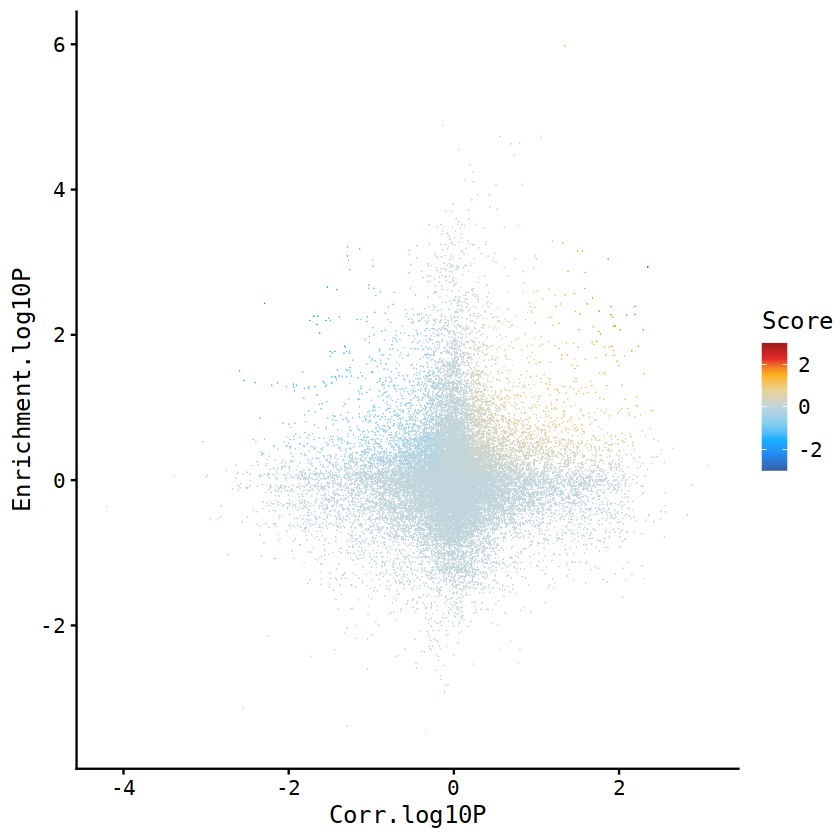

In [72]:
require(ggplot2)
require(ggrastr)
require(BuenColors) # https://github.com/caleblareau/BuenColors

figR.d %>% 
  ggplot(aes(Corr.log10P,Enrichment.log10P,color=Score)) + 
  ggrastr::geom_point_rast(size=0.01,shape=16) + 
  theme_classic() + 
  scale_color_gradientn(colours = jdb_palette("solar_extra"),limits=c(-3,3),oob = scales::squish,breaks=scales::breaks_pretty(n=3)) +
  cowplot_mono

Rank based visualization of drive TFs

In [109]:
rankDrivers(figR.d,score.cut = 1, rankBy = "nTargets",interactive = TRUE)

Ranking TFs by total number of associated DORCs ..


Using absolute score cut-off of: 1 ..




HTML widgets cannot be represented in plain text (need html)

Heatmap-based visualization of DORC-scores for candiate TFs and stron genes they regulate, based on DORC-associations.

Using absolute score cut-off of: 1 ..


Using Score as value column: use value.var to override.

Plotting 46 DORCs x 34TFs




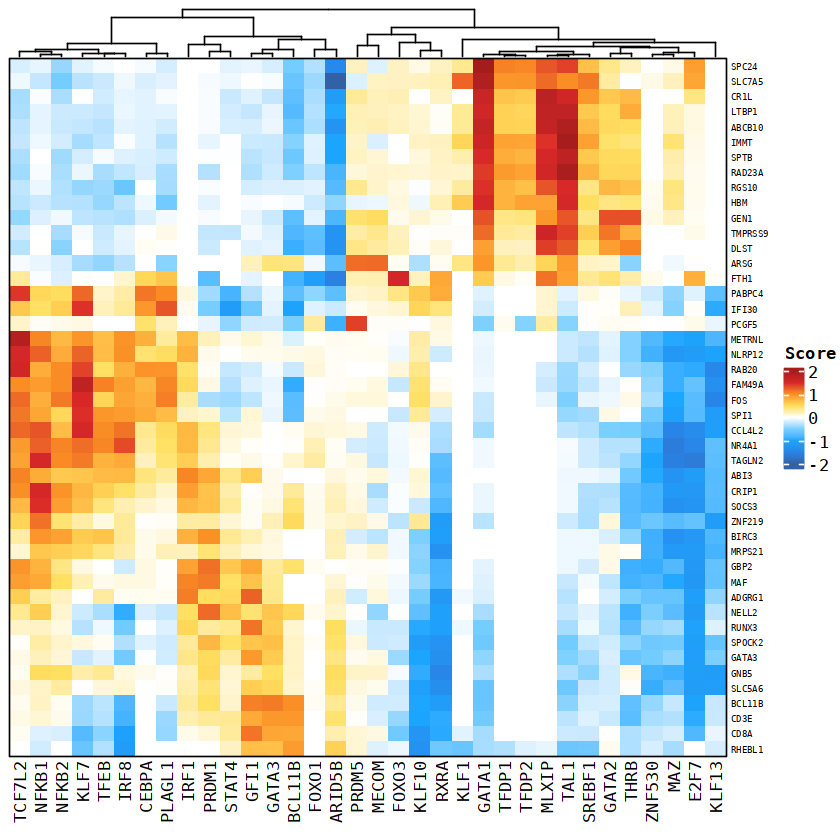

In [94]:
pushViewport(viewport(gp = gpar(fontfamily = "mono")));
heatmap <- plotfigRHeatmap(figR.d = figR.d,
                           score.cut = 1,
                           TFs = unique(figR.d$Motif),
                           column_names_gp = gpar(fontsize=10), # from ComplexHeatmap
                           show_row_dend = FALSE # from ComplexHeatmap
                          )
draw(heatmap, newpage = FALSE)
popViewport()


This visualization allows us to quickly identify the main TFs and their association with the regulation of potential target genes through DORCs in their genome neighborhoods. Alternatively, a network-based visualization of generated results can also be retrieved (using package networkD3)

In [1]:
library(networkD3)
library(r2d3)
library(imager)

Loading required package: magrittr


Attaching package: ‘imager’


The following object is masked from ‘package:magrittr’:

    add


The following objects are masked from ‘package:stats’:

    convolve, spectrum


The following object is masked from ‘package:graphics’:

    frame


The following object is masked from ‘package:base’:

    save.image




In [122]:
# generate the network
d3 <- plotfigRNetwork(figR.d,
                      score.cut = 1,
                      TFs = unique(figR.d$Motif),
                      weight.edges = TRUE)

In [ ]:
# in a local session, the network can be manipulated interactively
d3

In [152]:
# the network is saved as an image and shown for online purposes.
save_d3_png(
  d3,
  'network_tutorial_rna_n_atac.png',
  width = 992,
  height = 744,
  delay = 0.2,
  zoom = 1.6,
)

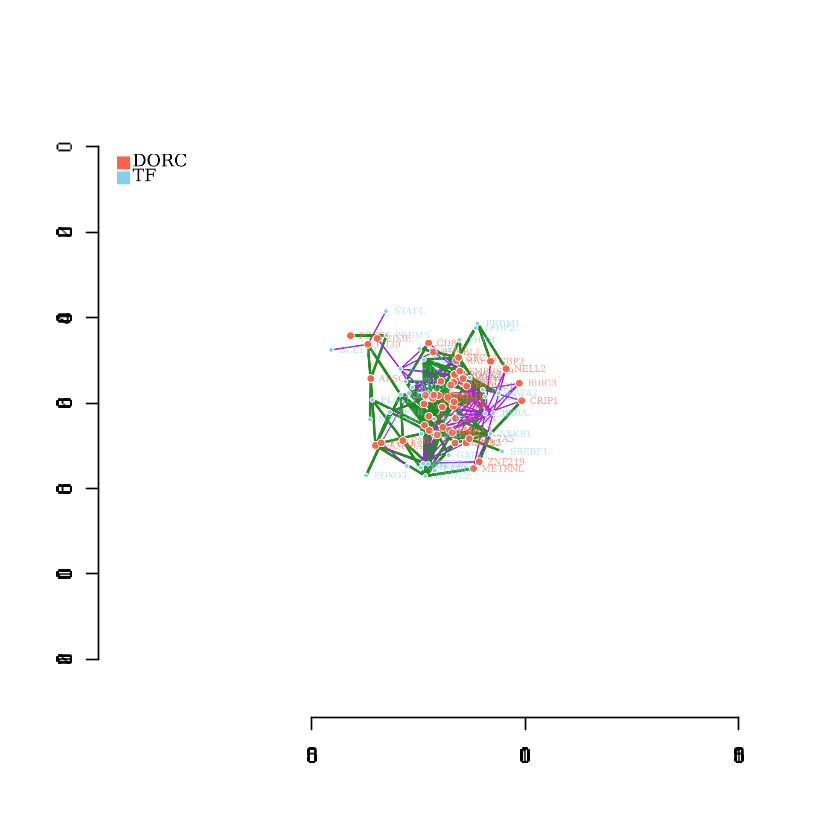

In [10]:
im <- load.image('network_tutorial_rna_n_atac.png')
plot(im)

Log of packages used to execute this notebook

In [120]:
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04 LTS

Matrix products: default
BLAS/LAPACK: /home/rio/miniconda3/envs/best_practices_regulons_rnanatac_test/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] r2d3_0.2.6                        networkD3_0.4                    
 [3] BuenColors_0.5.6                  MASS_7.3-58.1                    
 [5] patchwork_1.1.2                   ComplexHeatmap_2.10.0            
 [7] ggrastr_1.0.1                     doParallel_1.0.17                
 [9] ite

## Takeaways

In this notebook, we have:

1. Prepared an RNA and ATAC object using R, for processing with FigR and CisTopic.
2. Calculated DORC scores with FigR, and visualized those as scatter, heatmap and networks.

## Quiz

### Theory

1. Why are peak-to-gene associations considered mechanistically valid?
2. What are there more peaks than genes, and as consequence, multiple peaks targeting a single gene, when building GRNs?
3. What is considered a TF activator/repressor as the level of peak, and at the level of gene groups.
4. What additional readouts are complementary to scRNA-seq and scATAC-seq, when interpreting ATAC+RNA GRN models.

### FigR

1. What is the DORC score and how it could be useful to identify regulatory interactions between peaks and genes?

## References

```{bibliography}\n",
:filter: docname in docnames
:labelprefix: anno
```

## Contributors
We gratefully acknowledge the contributions of:
### Authorms
* Ignacio Ibarra
### Reviewers
* Lukas Heumos
* Anna Schaar